# Simple linear regression

_Datasets used in throughout this book can be downloaded [here](https://drive.google.com/drive/folders/1OkXMcFo0urN0kSQYH4d75I4V3pnSpV6H?usp=sharing)._

Let's return to the infant mortality dataset that we used in the previous section. We again load the dataset using `pandas`:

In [1]:
import pandas as pd

mortality_data = pd.read_csv('datasets/infant_mortality.csv')
mortality_data = mortality_data.dropna()
mortality_data.head()

,country,income,infant_mortality,region,oil
0,Australia,3426,26.7,Asia,no
1,Austria,3350,23.7,Europe,no
2,Belgium,3346,17.0,Europe,no
3,Canada,4751,16.8,Americas,no
4,Denmark,5029,13.5,Europe,no


Now we can transform the features `income` and `infant_mortality` to the (base-10) log scale, and plot a joint scatter plot of them.

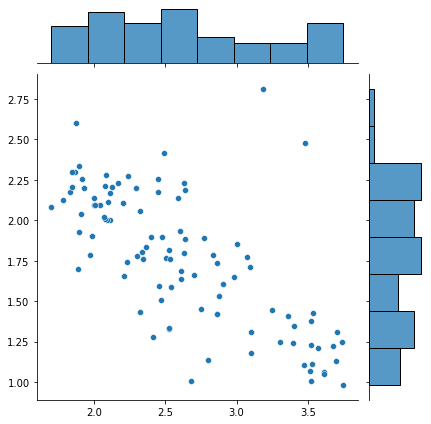

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# calling .to_numpy() on a column of a DataFrame gives you a numpy array back
log_income = np.log10(mortality_data["income"].to_numpy())
log_infant_mortality = np.log10(mortality_data["infant_mortality"].to_numpy())

sns.jointplot(x=log_income, y=log_infant_mortality)
plt.ylabel("log(Infant mortality rate)", fontsize=12)
plt.xlabel("log(Per-capita income)", fontsize=12)
plt.show()

## Computing correlation
Suppose we wanted to quantify the negative relationship between log-mortality and log-income. A simple way to do this would be with the Pearson correlation. For two vectors of observations $(x_1,\dots, x_n)$ and $(y_1,\dots,y_n)$, their Pearson correlation is computed as

$$
r = \frac{\text{Cov}(X, Y)}{\sqrt{\text{Var}(X)\text{Var}(Y)}} = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^n (x_i-\bar{x})^2 \sum_{i=1}^n (y_i - \bar{y})^2}}.
$$

Let's write a simple python function that computes the pearson correlation.

In [3]:
def pearson_corr(x,y):
    # first compute the means of the two vectors
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    # compute numerator (1/n)*\sum_i (x_i - x_bar)*(y_i - y_bar)
    cov_xy = np.sum((x-x_bar)*(y-y_bar))/len(x)

    # compute the variance of x and y
    var_x = np.sum((x-x_bar)**2)/len(x)
    var_y = np.sum((y-y_bar)**2)/len(y)

    # compute the correlation
    r = cov_xy/np.sqrt(var_x*var_y)

    return r

Now we can use this function to compute the correlation between log-income and log-mortality:

In [4]:
r = pearson_corr(log_income, log_infant_mortality)
r

-0.7086068160294182

Note that the Pearson correlation is bound between -1 and 1, with -1 indicating a perfect negative relationship between the features, and +1 indicating a perfect positive relationship between the features. Thus the observed value of $\approx -.71$ suggesting, as we can see visually, a strong negative relationship between log-infant mortality and log-per-capita income.

Of course, we don't really need to implement our own python function every time we want to compute the Pearson correlation. It's conveniently implemented in the `scipy.stats` library in python (which also includes a number of other methods that will be useful for statistics).

In [5]:
from scipy.stats import pearsonr

r_2, _ = pearsonr(log_income, log_infant_mortality)
r_2

-0.7086068160294183

Indeed, this method gives us the same result as we got with our own function.

## Finding the line of best fit by minimizing the sum of squares
Instead of just computing the correlation between the two features, we could also try to model the relationship by fitting a line to data. In particular, we want to find numbers $\alpha$ and $\beta$ such that

$$
\log_{10}(\text{infant mortality}) \approx \alpha + \beta \cdot \log_{10}(\text{per-capita income})
$$

To do this, we just need to find the values of $\alpha$ and $\beta$. Let's denote our obsevations of log-per-capita income by $(x_1,\dots,x_n)$ and those of log-infant mortality as $(y_1,\dots,y_n)$. Then one way to quantiatively choose $\alpha,\beta$ is by minimizing the sum of squared errors:

$$
\text{SSE}(\alpha, \beta) = \frac{1}{n}\sum_{i=1}^n (y_i - (\alpha +\beta x_i))^2
$$

> Remark: This is not the only choice we could have made. For example, we could have considered minimizing the sum of absolute errors, $\sum_i |y_i - (\alpha +\beta x_i)|$. However, using the SSE is mathematically much more convenient (since it is differentiable, and the absolute value is not), and so we will focus on this.

With a little bit of calculus, we can check that

$$
\begin{align*}
\frac{\partial}{\partial \alpha}\text{SSE} &= -2\sum_{i=1}^n (y_i - \alpha - \beta x_i) && \text{and}\\
\frac{\partial}{\partial \beta}\text{SSE} &= -2\sum_{i=1}^n x_i(y_i - \alpha - \beta x_i)
\end{align*}
$$

If we set these two derivatives equal to zero (to find the minimizers), we obtain the estimates $\hat{\alpha}$ and $\hat{\beta}$:

$$
\begin{align*}
\hat{\alpha} &= \bar{y} - \beta \bar{x}\\
\hat{\beta} &= \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i-\bar{x})^2}
\end{align*}
$$

Note that the expression for $\hat{\beta}$ looks very reminiscent of our equation for the Pearson correlation. Let's write a python function that takes in two arrays $(x_1,\dots,x_n)$ and $(y_1,\dots,y_n)$ computes the estimates $\hat{\alpha}$ and $\hat{\beta}$.

In [6]:
def fit_line(x, y):
    # first compute the means of the two vectors
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    # compute numerator (1/n)*\sum_i (x_i - x_bar)*(y_i - y_bar)
    cov_xy = np.sum((x-x_bar)*(y-y_bar))/len(x)

    # compute the variance of x and y
    var_x = np.sum((x-x_bar)**2)/len(x)

    # compute beta_hat
    beta_hat = cov_xy/var_x

    # compute alpha_hat
    alpha_hat = y_bar - beta_hat*x_bar

    return alpha_hat, beta_hat

Now let's use this to compute the coefficients for the line best fititng our data.

In [7]:
alpha_hat, beta_hat = fit_line(log_income, log_infant_mortality)
alpha_hat, beta_hat

(3.1033917572495335, -0.5117942628130397)

The intercept term $\hat{\alpha} \approx 3.1$ indicates that the best fit line crosses the y-axis at $y\approx 3.1$. The coefficient for the slope $\hat{\beta} \approx -0.51$ again indicates the negative relationship between log-income and log-infant mortality. Let's overlay this line on top of our joint scatterplot.

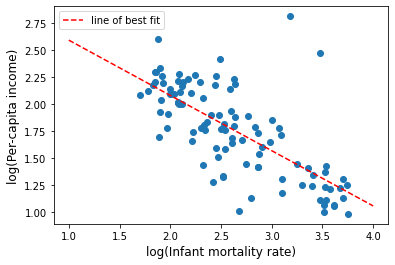

In [8]:
xx = np.linspace(1,4,5)
yy = alpha_hat + beta_hat*xx
plt.scatter(log_income, log_infant_mortality)
plt.plot(xx, yy, color='red', linestyle='--', label='line of best fit')
plt.xlabel("log(Infant mortality rate)", fontsize=12)
plt.ylabel("log(Per-capita income)", fontsize=12)
plt.legend()
plt.show()

## Interpreting the coefficients of a line of best fit

Before we proceed to explain how to interpret the coefficients of our log-mortality vs log-income regression, let's start with something simpler, where both variables are untransformed. As a simple example, let's consider a simple dataset containing measurements of height and weight.

In [9]:
height_weight_data = pd.read_csv("datasets/height_weight.csv")

Next, let's create a joint plot of height against weight.

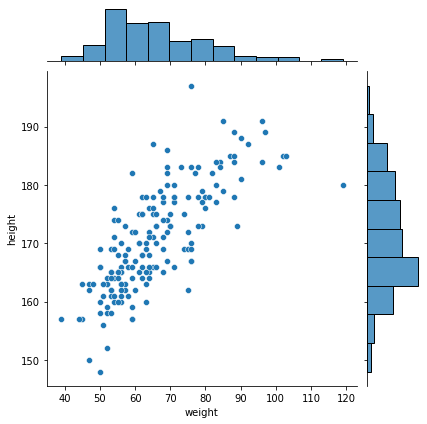

In [10]:
height = height_weight_data["height"]
weight = height_weight_data["weight"]

sns.jointplot(x=weight, y=height)
plt.ylabel("height (cm)", fontsize=12)
plt.xlabel("weight (kg)", fontsize=12)
plt.show()

In this case, we see that neither feature is particularly skewed, and that the trend relating the two appears to be roughly linear. Let's use the function we defined earlier to fit a line to this data.

alpha = 137.08690903754507, beta = 0.5124931451830912


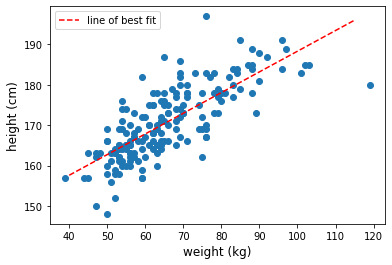

In [11]:
alpha_hat, beta_hat = fit_line(weight, height)
print(f"alpha = {alpha_hat}, beta = {beta_hat}")

xx = np.linspace(40,115,4)
yy = alpha_hat + beta_hat*xx
plt.scatter(weight, height)
plt.plot(xx, yy, color='red', linestyle='--', label='line of best fit')
plt.ylabel("height (cm)", fontsize=12)
plt.xlabel("weight (kg)", fontsize=12)
plt.legend()
plt.show()

We see visually that the line does a reasonable job of fitting the data. Let's now interpret the coefficients. The intercept term is $\hat{\alpha} \approx 137.1$, meaning that, at a weight of 0kg, the function $\hat{\alpha} + \hat{\beta}\text{weight}$ would predict a height of 137cm! Of course, this does not make much sense. As we will discuss in this class, we need to be careful when we interpret such predictions.

Next, let's consider the slope term $\hat{\beta} \approx 0.51$. From the equation $\text{height} \approx \hat{\alpha} + \hat{\beta}\text{weight}$, we see that we can interpret the coefficient $\hat{\beta}$ as follows: for a 1kg change in weight, we expect height to increase by approximately 0.5cm. More generally, the slope coefficient measures the expected _marginal_ change in the Y variable for a unit change in the X variable.

Now let us return to our example of income and infant mortality, where our model was

$$
\log_{10}(\text{infant mortality rate}) = 3.1 - 0.51\log_{10}(\text{per-capita income}).
$$

In this case our interpretation is slightly more subtle than in the height-weight example. In particular, it is no longer the case that a $\hat{\beta}$ represents the marginal effect on the Y variable of a unit change in the X variable. Instead, $\hat{\beta}$ represents the marginal effect on the _log_-infant mortality rate of a unit change in _log_-per-capita income. But what does a unit change in log-per-capita income mean? Let's suppose we have two values of income, $x$ and $x'$, such that

$$
\log_{10}(x) - \log_{10}(x') = 1 \implies \log_{10}\left(\frac{x}{x'}\right) =1 \implies \frac{x}{x'} = 10.
$$

Thus a unit change in (base-10) log-per-capita income corresponds to a _factor of 10_ increase in the original variable! This is generally the case when working with log units: it measures multiplicative changes, rather than additive changes. Since we also transformed the infant mortality rate variable, we need to apply a similar interpretation to it. When log-per-capita income increases by a 1 unit, log-infant mortality decreases by $\approx 1/2$ units. To see what a decrease in log-infant mortality by $1/2$ means, we can check

$$
\log_{10}(y) - \log_{10}(y') = -1/2 \implies \frac{y}{y'} = 10^{-1/2} \approx  1/3.
$$

So a decrease in log-infant mortality by $1/2$ correponds to decreasing infant mortality by a factor of approximately 3. Putting everything together, we can interpret the coefficient $\hat{\beta} = 0.51$ in terms of the untransformed variables as follows: increasing per-capita income by a factor of 10 will roughly results in a decrease in infant-mortality rate by a factor of 3. We can make similar interpretations for models that only transform the X variable and not the Y, or vice versa.

It's important to note that when we make statements such as the interpretations above, it is under the assumption that the model we've proposed is approximately correct. At this stage, we do not have the necessary tools to quantitatively evaluate such an assumption, though in the coming sections we will develop a variety of ways to analyze and diagnose the quality of models we fit in a rigorous statistical framework.